In [1]:
from Functions import *
import winsound

# Preliminary

In [2]:
def define_beamline_normal(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=141.6, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

### 1. common simulation parameters

In [3]:
##### ''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 9481        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

##### common simulation parameters
m1_p = 185.0; m1_q = -58.0
m2_p = 175.75711407315083
m2_p1 = 4988.789219651727    # 70% all correction value
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 9.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 13.0    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'm2_p_optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}mm_offset/'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset); make_dir(dir_plot)


path exists
path exists
path exists

CWD: output/9481eV/m2_p_optimization/
path exists
path exists


### 2. calculate crystal dimensions and slit width

In [4]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices_calc, mono_beamline_calc = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1_calc = beam.Beam(beam_params=beam_params)
b2_calc = mono_beamline_calc.propagate_beamline(b1_calc)

In [5]:
# get crytal properties
beta0s = []; braggs = []; asyms = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm\n'.format(np.round(l_crystal*1e3/2,  3)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [12.043 12.037 19.912 19.91  42.928 42.928]
asymmetry: [ -9.   9. -13.  13.   0.  15.]
beam size: [8.854 1.311 5.911 1.311 1.31  0.724] mm
footprint: [24.665 24.674 10.879 10.886  1.924  1.546] mm

calculated slit width: 0.84um
actual slit width: 3.0um



### 3. load shapeErrors

70%_shapeError_20.969W_0.759W_6.414W_0.208W_2.505W_0.313W
(5637, 2)
(5637, 2)
(4517, 2)
(4517, 2)
(1157, 2)
(1157, 2)


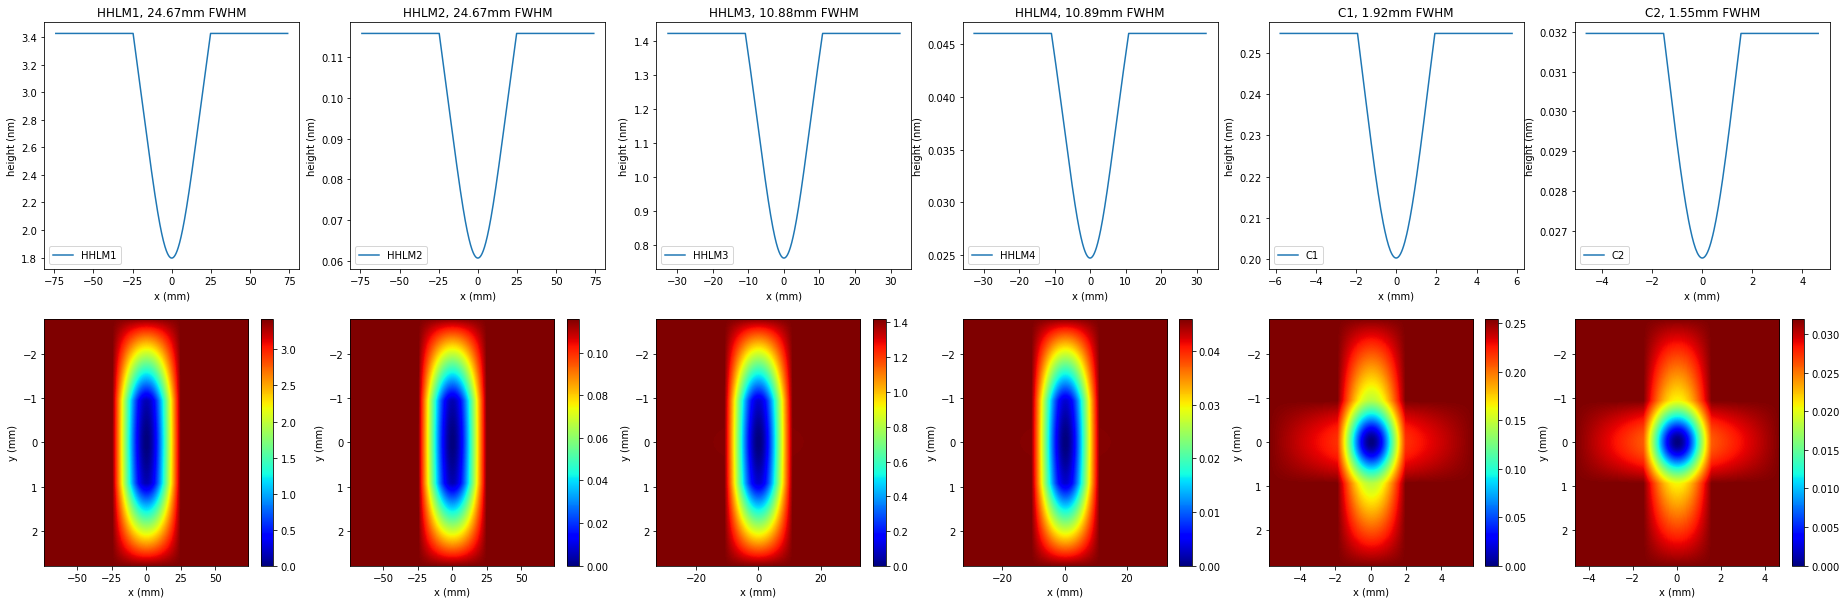

In [6]:
power_percentage = 70
if_pad = 1

# crystal_powers = np.array([29.9778, 0.7356, 0.7410, 1.6837, 10.9076, 0.4703])*power_percentage/100    # crytal power for Zigzag-111-220 asymmetric
# crystal_powers = np.array([29.9978, 10.2117, 0.2467, 0.2344, 3.4120, 0.4440])*power_percentage/100    # crytal power for Zigzag-111-220 symmetric
# crystal_powers = np.array([29.9552, 1.0849, 6.3846, 0.8192, 5.8204, 0.4589])*power_percentage/100    # crytal power for 2DCM-111-220 asymmetric, 16.9
# crystal_powers = np.array([29.9552, 1.0849, 10.3877, 0.1849, 2.4811, 0.4364])*power_percentage/100    # crytal power for 2DCM-111-220 asymmetric, 9.0
crystal_powers = np.array([29.9552, 1.0849, 9.1635, 0.2965, 3.5789, 0.4476])*power_percentage/100    # crytal power for 2DCM-111-220 asymmetric, 13.0

# crystal_powers *= np.array([1,0,0,0,0,0])

# directories
dir_profile = '../DXS_Xtals_FEA4WFS/{}/'.format(HHLM_type)

# get file name based on crystal powers
fname_error = '{}%_shapeError'.format(power_percentage)
for i in range(n_crys):
    fname_error += '_{}W'.format(round(crystal_powers[i],3))
print(fname_error)

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

if HHLM_type == 'Zigzag':
    crystal_profile_powers = np.array([
        [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
        [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
        [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
    ])
elif HHLM_type == '2DCM':
    crystal_profile_powers = np.array([
        [73.15, 0.027, 16.53, 0.029, 0.026, 0.03],
        [73.15, 0.015, 16.79, 0.015, 0.014, 0.013],
        [4.51, 1.69, 50.1, 1.78, 1.61, 1.88]
    ])

# choose shapeError profiles with the closest power
ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])
ratio_power[ratio_power<1] = 1/(ratio_power[ratio_power<1])
options = ratio_power.argmin(axis=0)+1

# load
for i, crystal in enumerate(crystals):
    if crystal_powers[i] == 0: continue
    # load profiles from file
    dy, xx, zz = load_crystal_data(dir_profile, crystal, options[i])
    # proportionality constant due to power and crystal dimension
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    height_factor2 = (l_crystal[i]*1e3/(xx.max()-xx.min()))*(w_crystal[i]*1e3/(zz.max()-zz.min()))
    shapeErrors[i] = dy*1e6 * height_factor1 / height_factor2    # [nm]
    nx, ny = shapeErrors[i].shape; end_val = shapeErrors[i].max()
    if if_pad == 1:
        # stretch in both directions
        shapeErrors[i] = np.pad(shapeErrors[i],
                                pad_width=((nx,nx),(ny,ny)), mode='linear_ramp',
                                end_values = ((end_val,end_val),(end_val,end_val)))
        # modify dimensions for the new profile
        l_crystal[i] *= 3; w_crystal[i] *= 3
        # new crytal axis
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny*3)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx*3)
    else:
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx)


# plot
n_subplot = np.sum(crystal_powers!=0)
plt.figure(figsize=(n_subplot*5+2, 10))
i_plot = 0
for i in range(n_crys):
    if crystal_powers[i] == 0: continue
    i_plot += 1
    plt.subplot(2, n_subplot, i_plot)
    plt.plot(x_mirs[i]*1e3, shapeErrors[i][1024,:], label=crystals[i])
    plt.legend(); plt.xlabel('x (mm)'); plt.ylabel('height (nm)')
    if if_pad == 1:
        plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3/3,2)))
    else:
        plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3,2)))
    plt.subplot(2, n_subplot, i_plot+n_subplot)
    plt.imshow(shapeErrors[i], cmap='jet',
              extent = [x_mirs[i].min()*1e3, x_mirs[i].max()*1e3, y_mirs[i].max()*1e3, y_mirs[i].min()*1e3])
    plt.colorbar(); plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.axis('tight')
    
plt.savefig(dir_plot+'Bumps_'+fname_error+'.png')

### Beam profiles

In [7]:
%%capture capt
screen_names = ['im_input','im_after_HHLM4','im_focus','im_out']

# perfect case
mono_devices_p, mono_beamline_p = define_beamline_normal(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=[None for i in range(6)],
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
pulse_p = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
pulse_p.propagate(beamline=mono_beamline_p,screen_names=screen_names)

# shapeError with mirror bending
mono_devices_m, mono_beamline_m = define_beamline_normal(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_p=m2_p1,
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=shapeErrors,
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
pulse_m = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
pulse_m.propagate(beamline=mono_beamline_m,screen_names=screen_names)

dir_profile = dir_plot+'profiles_{}%/'.format(power_percentage); make_dir(dir_profile)

C:\Users\nanw0\anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


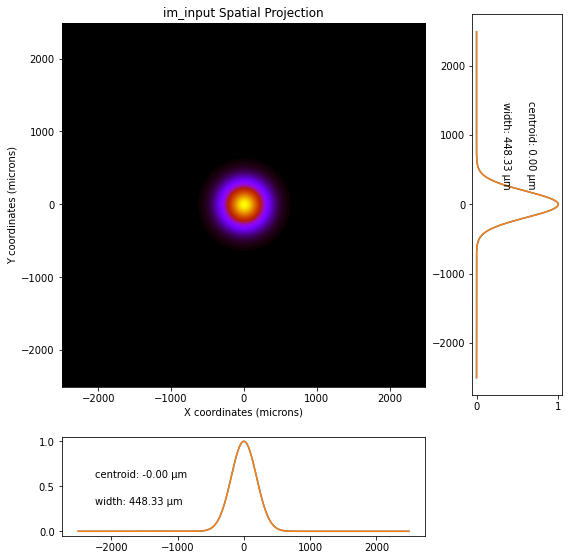

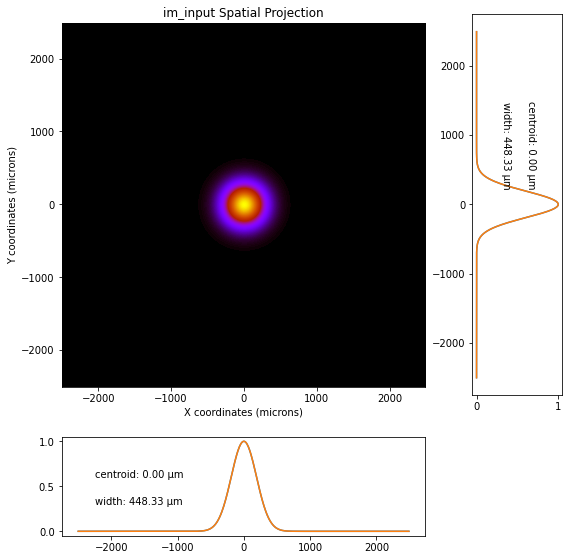

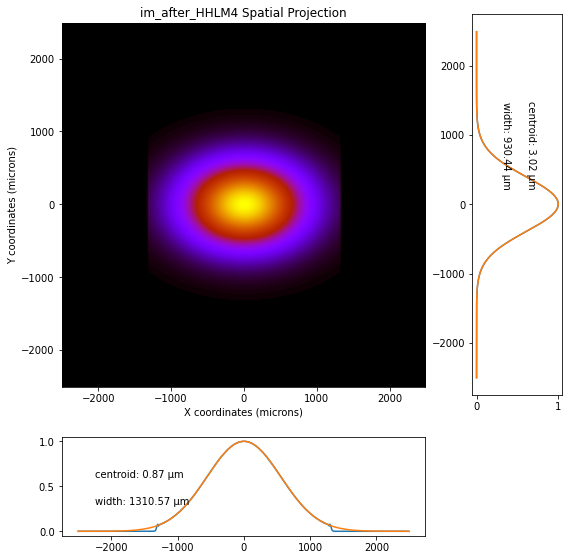

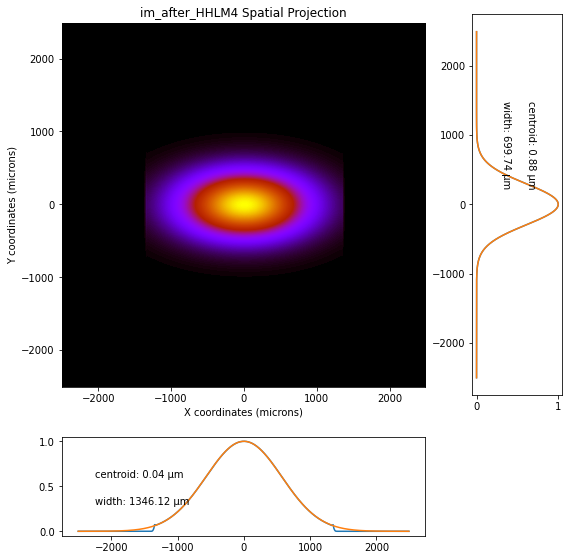

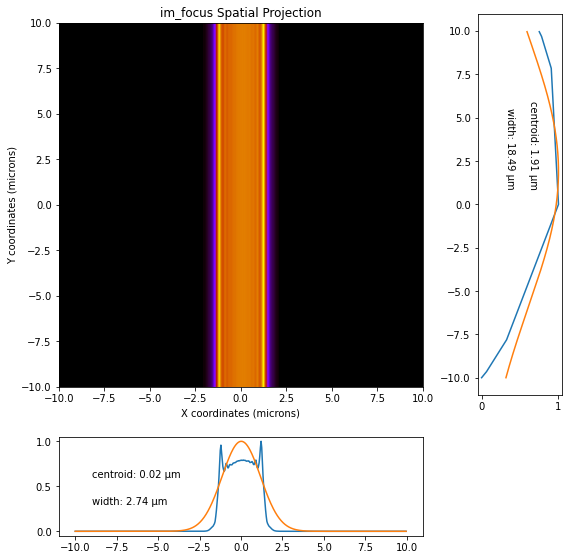

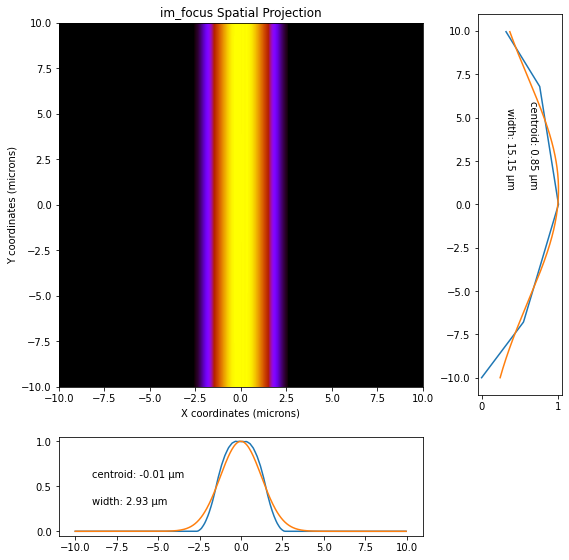

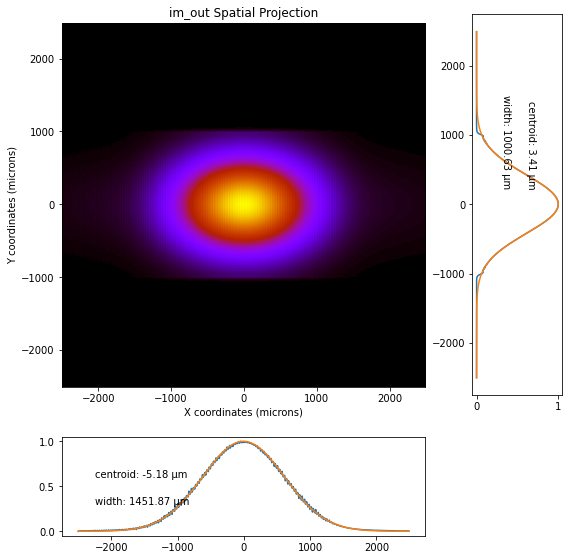

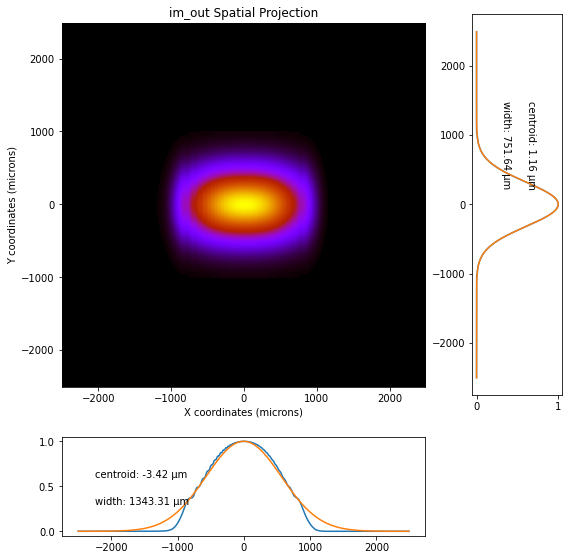

In [8]:
''' projection '''
for i,screen_name in enumerate(screen_names):
    try:
        pulse_p.imshow_projection(screen_name); plt.savefig(dir_profile+'projection_{}_perfect.png'.format(i+1))
        pulse_m.imshow_projection(screen_name); plt.savefig(dir_profile+'projection_{}_mirror_bending.png'.format(i+1))
    except:
        print(screen_name, 'failed')

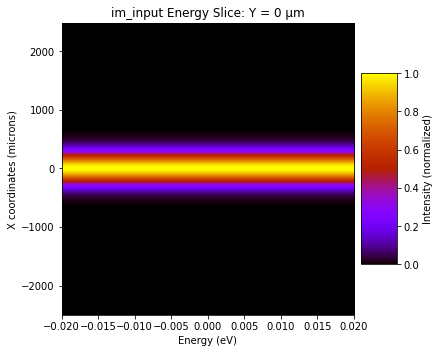

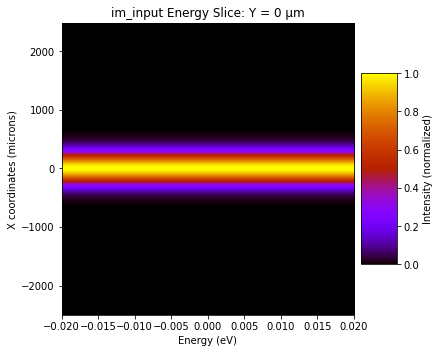

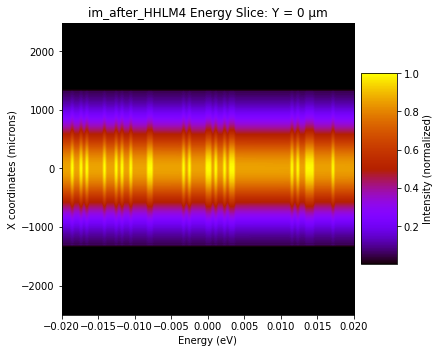

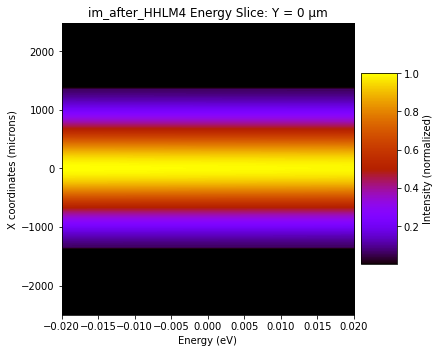

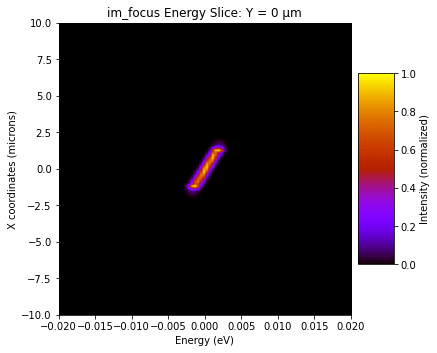

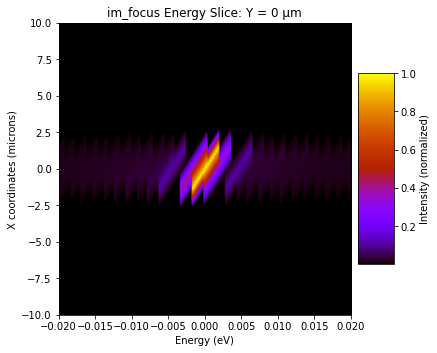

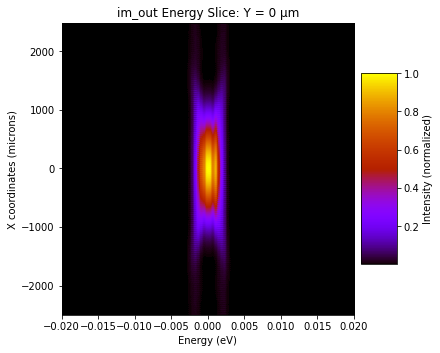

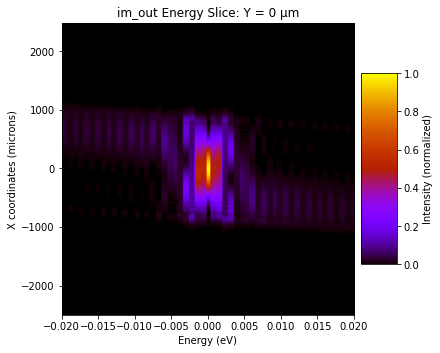

In [9]:
''' energy slices '''
for i,screen_name in enumerate(screen_names):
    try:
        pulse_p.imshow_energy_slice(screen_name); plt.savefig(dir_profile+'spectrum_{}_perfect.png'.format(i+1))
        pulse_m.imshow_energy_slice(screen_name); plt.savefig(dir_profile+'spectrum_{}_mirror_bending.png'.format(i+1))
    except:
        print(screen_name, 'failed')

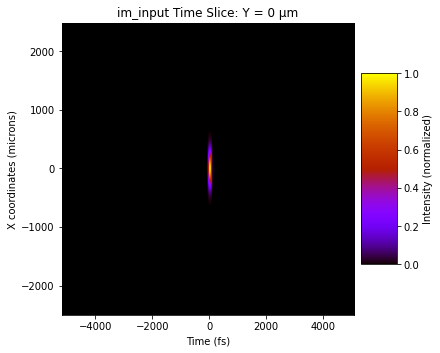

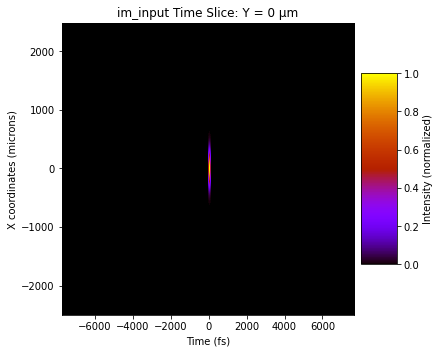

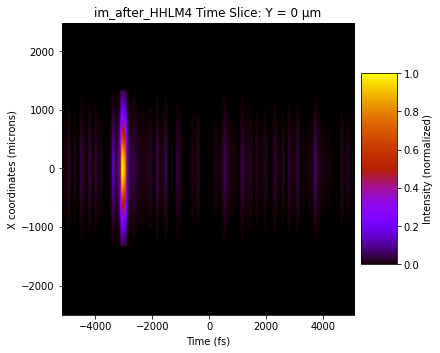

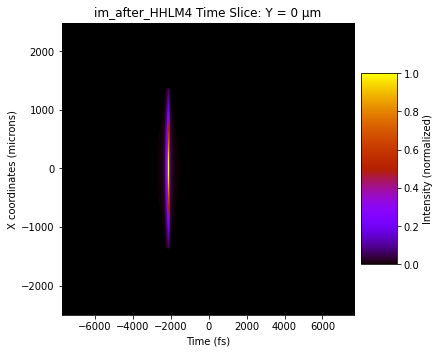

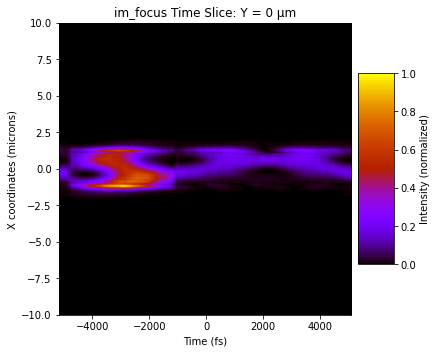

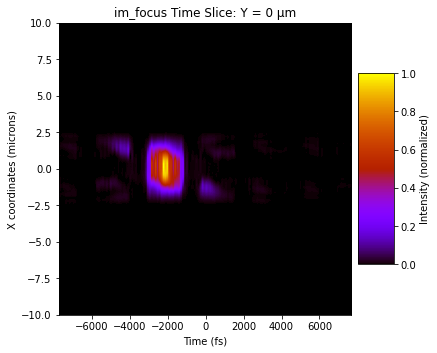

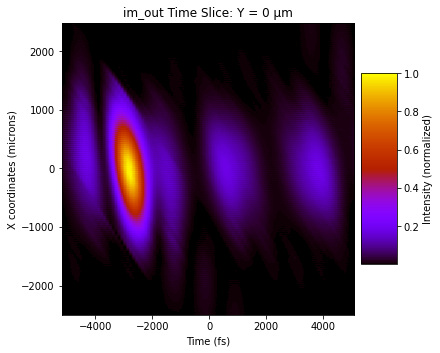

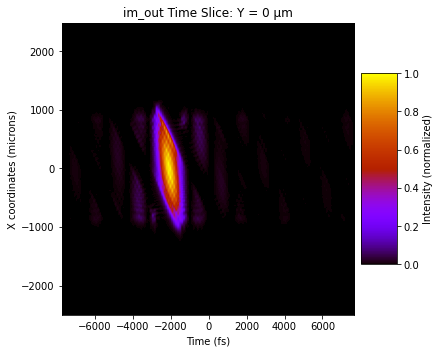

In [10]:
''' time slices '''
shift = 0
for i,screen_name in enumerate(screen_names):
    try:
        pulse_p.imshow_time_slice(screen_name, shift=shift); plt.savefig(dir_profile+'tilt_{}_perfect.png'.format(i+1))
        pulse_m.imshow_time_slice(screen_name, shift=shift); plt.savefig(dir_profile+'tilt_{}_mirror_bending.png'.format(i+1))
    except:
        print(screen_name, 'failed')

In [11]:
''' diagnostics '''
# perfect
c, pulse_duration0 = pulse_p.pulse_duration('im_out')
pulse_tilt0 = pulse_p.pulsefront_tilt('im_out')
spatial_chirp0 = pulse_p.spatial_chirp('im_out')
energy_bandwidth0 = pulse_p.pulse_bandwidth('im_out')
throughput0 = pulse_p.throughput('im_input','im_out')
print('duration {}fs'.format(pulse_duration0))
print('tilt {}fs/um'.format(pulse_tilt0))
print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
print('bandwidth {}meV'.format(energy_bandwidth0*1e3))
print('throughput {}%'.format(throughput0*1e2))
np.savetxt(dir_plot+'diagnostics_perfect.txt',np.array([pulse_duration0, pulse_tilt0, spatial_chirp0*1e3, energy_bandwidth0*1e3]), delimiter=',')

# shapeError with mirror bending
c, pulse_duration1 = pulse_m.pulse_duration('im_out')
pulse_tilt1 = pulse_m.pulsefront_tilt('im_out')
spatial_chirp1 = pulse_m.spatial_chirp('im_out')
energy_bandwidth1 = pulse_m.pulse_bandwidth('im_out')
throughput1 = pulse_m.throughput('im_input','im_out')
print('\nduration {}fs'.format(pulse_duration1))
print('tilt {}fs/um'.format(pulse_tilt1))
print('spatial chirp {}meV/um'.format(spatial_chirp1*1e3))
print('bandwidth {}meV'.format(energy_bandwidth1*1e3))
print('throughput {}%'.format(throughput1*1e2))
np.savetxt(dir_plot+'diagnostics_bending_'+fname_error+'.txt',np.array([pulse_duration1, pulse_tilt1, spatial_chirp1*1e3, energy_bandwidth1*1e3]), delimiter=',')


duration 883fs
tilt -0.30546263166365695fs/um
spatial chirp 4.432467859369818e-05meV/um
bandwidth 2.7875985501678633meV
throughput 26.839779849883925%

duration 806fs
tilt -0.31339806762270733fs/um
spatial chirp -0.0006594289202232018meV/um
bandwidth 2.443222407227613meV
throughput 18.318440863978346%


In [12]:
import winsound
winsound.Beep(1500, 3000)